We want to compensate for images where the difference between ref & current is opposite the expected difference, according to the lable.

* Obstacle images are expected a high difference.
* No Obstacle images are expected a low difference. 

Overall flow is:
* Define a function to score the level of difference between ref & current (0.0-1.0).

* Use this score as is for No Obstacle images - this will compensate for No Obstacle images having a high difference score.

* Use (1 - score) for Obstacle images - this will compensate for Obstacle images having a low difference score.

* Usage of the score is by means of tf.keras 'sample-weight', which is a loss-coefficient attached to every data item, in order to provide more weight to some samples. 

    We will use:
        sample_weight = 1 + diff_coef

This notebook experiments with a few samples of each class (Obstacle, No Obstacle), representing typical cases of low/high diffrence between ref/current. It generates the score described above accordingly.

In order to control the effect of this coefficient on the overall loss, we'll multiply it by some positive float swc (sample weight coefficient. 

So the sample_weight will look like:

    sample_weight =  swc * (1 + diff_coef). 

## Imports

In [1]:
import cv2
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.pyplot import title

## Settings

In [2]:
imdir = '/home/drevital/obstacles_classification_datasets/test_image_diff'
threshold = 50

In order for the ref/current difference score to achieve its goals, as defined above, we calculate it as follows:

* Generate a mask of the ref/current subtratcion image. All pixels above defined threshold in the subtraction image receive maximum value (255). All pixels below the threshold receive 0 value.

* Calculate diff_metric - the relative amount of white pixels in the mask image vs. all pixels in the image (0.0-1.0).

* Calculate the mean and the std (standard deviation) of the diff_metric of all sample images.

* Assign the dif_coef according to a curve, translating the Sigma (amounf of std's) to a value between 0.0-1.0, as in this sample curve:

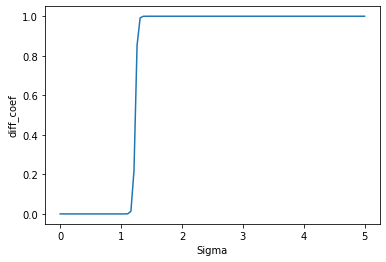

The curve is based on the Sigmoid function: 1/(1 + np.exp(-x))

with adding alfa, beta and gamma modifiers to enable controlling the curve's attributes:

* alfa. Narows the range of the cliffy curve to [0, 1]

* beta. controls the point where the graph starts to increase sharply

* gamma. controls the width of the sharply declining portion of the curve. The bigger gamma == sharper cliff.

After adding above controls the Sigmoid-modified function becomes:

* 1/(1 + np.exp(-(xalfa-beta)gamma))

In [3]:
# Parameters used in the diff_metric to diff_coef assignent function
alfa = 3
beta = 3.7
gamma = 8
swc = 1.0 # sample weight coefficient

## Load Images Utility

In [4]:
def load_images_from_folder(folder):
    imnames = []
    images = []
    for imname in os.listdir(folder):
        imrgb = cv2.imread(os.path.join(folder,imname))
        im = cv2.cvtColor(imrgb, cv2.COLOR_BGR2RGB)        
        if im is not None:
            imnames.append(imname)
            images.append(im)
    return imnames, images

## Read images, Separate them to <ref, current> and Display <ref, current>

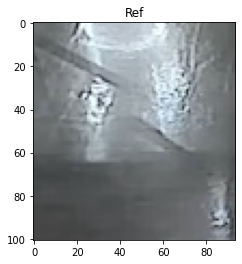

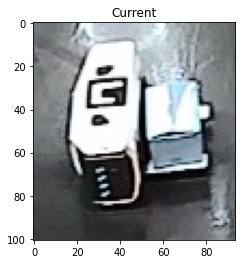

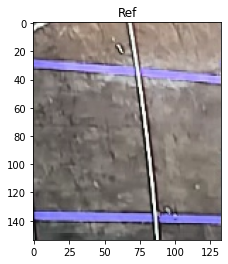

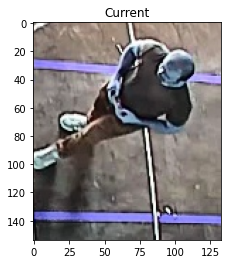

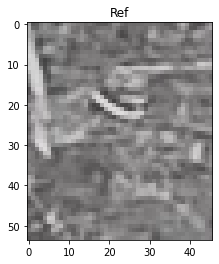

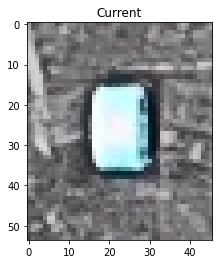

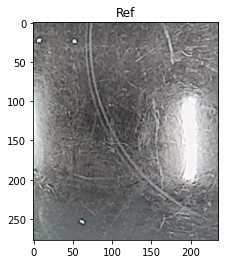

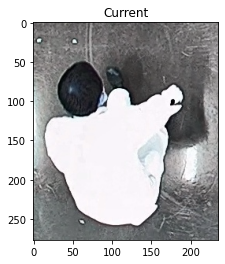

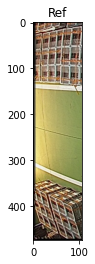

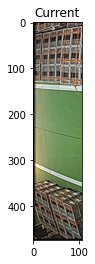

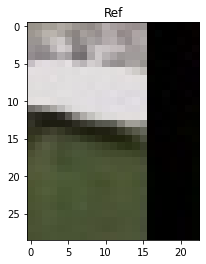

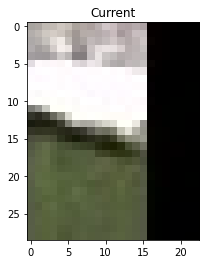

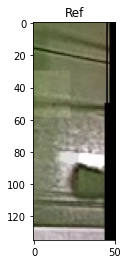

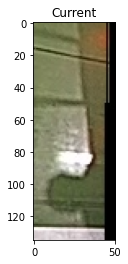

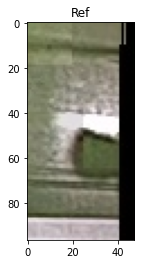

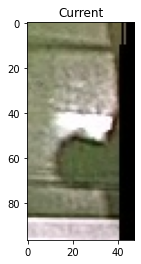

In [5]:
obs_folder = os.path.join(imdir, 'obstacle')
obs_imnames, obs_images = load_images_from_folder(obs_folder)
no_obs_folder = os.path.join(imdir, 'no_obstacle')
no_obs_imnames, no_obs_images = load_images_from_folder(no_obs_folder)

obs_refs = []
obs_currents = []
no_obs_refs = []
no_obs_currents = []

for imrgb in obs_images:
    im = cv2.cvtColor(imrgb, cv2.COLOR_BGR2RGB)        
    w = im.shape[1]
    ref = im[:, :w//2]
    current = im[:, w//2:]
    obs_refs.append(ref)
    obs_currents.append(current)
    
    plt.imshow(ref)
    plt.title('Ref')
    plt.show()

    plt.imshow(current)
    plt.title('Current')
    plt.show()
    
for imrgb in no_obs_images:
    im = cv2.cvtColor(imrgb, cv2.COLOR_BGR2RGB)        
    w = im.shape[1]
    ref = im[:, :w//2]
    current = im[:, w//2:]
    no_obs_refs.append(ref)
    no_obs_currents.append(current)
    
    plt.imshow(ref)
    plt.title('Ref')
    plt.show()

    plt.imshow(current)
    plt.title('Current')
    plt.show()

## Calculate diff_metric's, masks's, mean & std

### Obstacle

In [6]:
obs_masks = []
obs_diff_metrics = []

for ref, current in zip(obs_refs, obs_currents):
    diff = cv2.subtract(ref, current)
    agg_rgb = np.stack((diff[:, :, 0], diff[:, :, 1], diff[:, :, 2])).max(0)
    _, mask = cv2.threshold(agg_rgb, threshold, 255, cv2.THRESH_BINARY)

    # Calculate diff_coeff
    h = mask.shape[0]
    w = mask.shape[1]
    area = h * w
    
    obs_diff_metrics.append(1.0 - (np.sum(mask)/255)/area)    
    obs_masks.append(mask)   
    
obs_mean = np.mean(obs_diff_metrics)
obs_std = np.std(obs_diff_metrics)

### No Obstacle

In [7]:
no_obs_masks = []
no_obs_diff_metrics = []

for ref, current in zip(no_obs_refs, no_obs_currents):
    diff = cv2.subtract(ref, current)
    agg_rgb = np.stack((diff[:, :, 0], diff[:, :, 1], diff[:, :, 2])).max(0)
    _, mask = cv2.threshold(agg_rgb, threshold, 255, cv2.THRESH_BINARY)

    # Calculate diff_coeff
    h = mask.shape[0]
    w = mask.shape[1]
    area = h * w
    
    no_obs_diff_metrics.append(1.0 - (np.sum(mask)/255)/area)    
    no_obs_masks.append(mask)   
    
no_obs_mean = np.mean(no_obs_diff_metrics)
no_obs_std = np.std(no_obs_diff_metrics)

In [8]:
obs_mean, obs_std, no_obs_mean, no_obs_std

(0.8618194545853113,
 0.04296309254665015,
 0.8841816212873361,
 0.12733047956773566)

## Define curve to assign diff_coef according to diff_metric
as described in detail in a previous cell of this notebook

In [21]:
def diff_metric_to_diff_coef(sigma_dist):
    
    # Based on Sigmoid
    # adding alpha, beta and gamma controls, as explained at the
    # beginning of this notebook
    
    return 1/(1 + np.exp(-(sigma_dist*alfa-beta)*gamma))

## Assign diff_coef's according to diff_metric's and the defined curve

In [10]:
obs_diff_coefs = []
obs_sample_weights = []

for obs_diff_metric in obs_diff_metrics:
    sigma_dist = abs(obs_diff_metric - obs_mean)/obs_std
    obs_diff_coef = diff_metric_to_diff_coef(sigma_dist)
    obs_sample_weight = 1.0 + swc * obs_diff_coef
    print(f'obs_diff_metric: {obs_diff_metric:.3f}', end=' ')
    print(f'sigma_dist: {sigma_dist:.3f}', end=' ')
    print(f'obs_diff_coef: {obs_diff_coef:.3f}', end=' ')
    print(f'obs_sample_weight: {obs_sample_weight:.3f}')
    obs_diff_coefs.append(obs_diff_coef)
    obs_sample_weights.append(obs_sample_weight)

obs_diff_metric: 0.830 sigma_dist: 0.741 obs_diff_coef: 0.000 obs_sample_weight: 1.000
obs_diff_metric: 0.811 sigma_dist: 1.174 obs_diff_coef: 0.193 obs_sample_weight: 1.193
obs_diff_metric: 0.918 sigma_dist: 1.305 obs_diff_coef: 0.847 obs_sample_weight: 1.847
obs_diff_metric: 0.888 sigma_dist: 0.610 obs_diff_coef: 0.000 obs_sample_weight: 1.000


In [11]:
obs_diff_coefs

[7.327482946567627e-06,
 0.19276407898775832,
 0.8472710224584616,
 3.154151729300079e-07]

In [12]:
no_obs_diff_coefs = []
no_obs_sample_weights = []

for no_obs_diff_metric in no_obs_diff_metrics:
    sigma_dist = abs(no_obs_diff_metric - no_obs_mean)/no_obs_std
    no_obs_diff_coef = diff_metric_to_diff_coef(sigma_dist)
    no_obs_sample_weight = 1.0 + swc * no_obs_diff_coef
    print(f'no_obs_diff_metric: {no_obs_diff_metric:.3f}', end=' ')
    print(f'sigma_dist: {sigma_dist:.3f}', end=' ')
    print(f'no_obs_diff_coef: {no_obs_diff_coef:.3f}', end=' ')
    print(f'no_obs_sample_weight: {no_obs_sample_weight:.3f}')
    no_obs_diff_coefs.append(no_obs_diff_coef)
    no_obs_sample_weights.append(no_obs_sample_weight)

no_obs_diff_metric: 0.670 sigma_dist: 1.684 no_obs_diff_coef: 1.000 no_obs_sample_weight: 2.000
no_obs_diff_metric: 1.000 sigma_dist: 0.910 no_obs_diff_coef: 0.000 no_obs_sample_weight: 1.000
no_obs_diff_metric: 0.916 sigma_dist: 0.249 no_obs_diff_coef: 0.000 no_obs_sample_weight: 1.000
no_obs_diff_metric: 0.951 sigma_dist: 0.525 no_obs_diff_coef: 0.000 no_obs_sample_weight: 1.000


In [13]:
no_obs_diff_coefs

[0.9999797943962937,
 0.0004220904769146016,
 5.516167889452777e-11,
 4.140565576639647e-08]

## Display images, their masks & their sample_weight (as mask's title)

### Obstacle

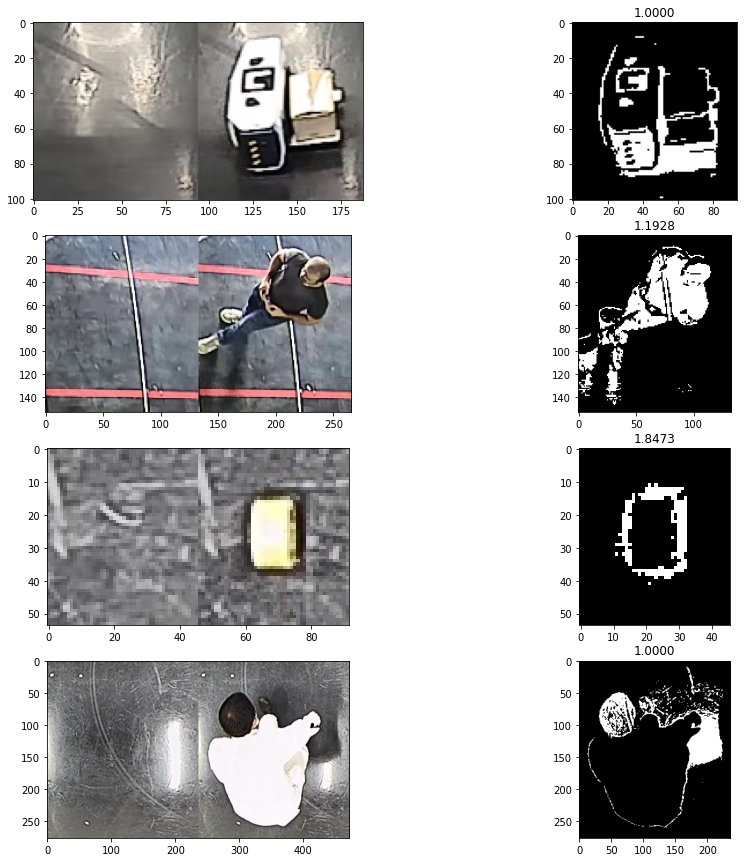

In [14]:
rows = len(obs_images)
cols = 2
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(15,15))

for i in range(rows):
    axes[i, 0].imshow(obs_images[i])
    axes[i, 1].set_title(f'{obs_sample_weights[i]:.4f}')
    axes[i, 1].imshow(obs_masks[i], cmap='gray', vmin=0, vmax=255) 

### No Obstacle

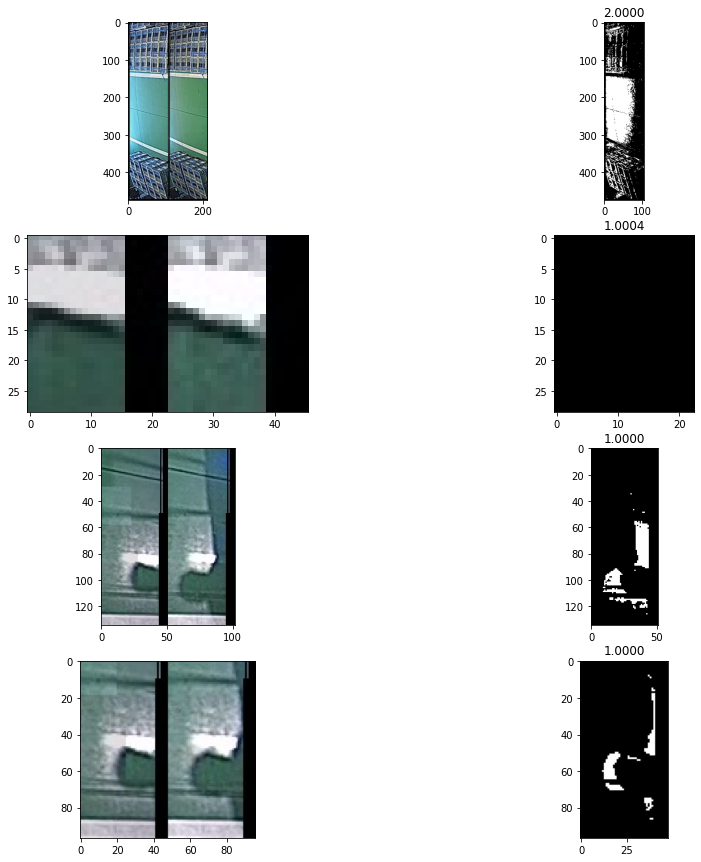

In [15]:
rows = len(no_obs_images)
cols = 2
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(15,15))

for i in range(rows):
    axes[i, 0].imshow(no_obs_images[i])
    axes[i, 1].set_title(f'{no_obs_sample_weights[i]:.4f}')
    axes[i, 1].imshow(no_obs_masks[i], cmap='gray', vmin=0, vmax=255) 

## Create a dictionary mapping filenames to sample_weights

In [16]:
no_obs_size = len(no_obs_imnames)
obs_size = len(obs_imnames)

train_dict = {'fname': no_obs_imnames + obs_imnames,
              'label': ['no_obstacle']*no_obs_size + ['obstacle']*obs_size,
              'sample_weight': no_obs_sample_weights + obs_sample_weights}

In [17]:
train_dict

{'fname': ['1_49_.52_2021-08-15--16-48-27_.jpg',
  '1_27_.07_2021-08-15--18-13-15_.jpg',
  '1_58_.77_2021-08-15--18-13-19_.jpg',
  '1_43_.74_2021-08-15--18-13-17_.jpg',
  '18_973_.98_2021-08-16--15-29-43_.jpg',
  '16_841_.98_2021-08-16--09-51-40_.jpg',
  '14_539_.89_2021-08-17--18-09-33_.jpg',
  '14_629_1.00_2021-08-17--18-09-43_.jpg'],
 'label': ['no_obstacle',
  'no_obstacle',
  'no_obstacle',
  'no_obstacle',
  'obstacle',
  'obstacle',
  'obstacle',
  'obstacle'],
 'sample_weight': [1.9999797943962938,
  1.0004220904769145,
  1.0000000000551617,
  1.0000000414056558,
  1.0000073274829466,
  1.1927640789877583,
  1.8472710224584616,
  1.0000003154151729]}

## Create Dataframe from sample_weights Dictionary

In [18]:
train_df = pd.DataFrame.from_dict(train_dict)

In [19]:
train_df

,fname,label,sample_weight
0,1_49_.52_2021-08-15--16-48-27_.jpg,no_obstacle,1.999980
1,1_27_.07_2021-08-15--18-13-15_.jpg,no_obstacle,1.000422
2,1_58_.77_2021-08-15--18-13-19_.jpg,no_obstacle,1.000000
3,1_43_.74_2021-08-15--18-13-17_.jpg,no_obstacle,1.000000
4,18_973_.98_2021-08-16--15-29-43_.jpg,obstacle,1.000007
5,16_841_.98_2021-08-16--09-51-40_.jpg,obstacle,1.192764
6,14_539_.89_2021-08-17--18-09-33_.jpg,obstacle,1.847271
7,14_629_1.00_2021-08-17--18-09-43_.jpg,obstacle,1.000000


In [20]:
csv_path = os.path.join(imdir, 'test_image_diff.csv')
train_df.to_csv(csv_path)